In [1]:
# load libs# load  
import torch
import argparse
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from data.datasets import MNIST
import torch.utils.data as data_utils
from sklearn.decomposition import PCA
import torch.nn.functional as F
from torch.autograd import Variable

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
'''
@ Original 28x28 is rescaled to 32x32 to meet 2^P size
@ batch_size and workders can be increased for faster loading
'''
print(torch.__version__)
print(np.__version__)
sample_num = 1000
low_channel = 15
mid_channel = 15
hig_channel = 16 - mid_channel
batch_size=1
test_batch_size=1
kwargs={}
train_loader = data_utils.DataLoader(MNIST(root='./data',train=True,process=False,transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])),batch_size=batch_size,shuffle=False,**kwargs)


test_loader = data_utils.DataLoader(MNIST(root='./data',train=False,process=False,transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])),batch_size=test_batch_size,shuffle=False,**kwargs)

0.3.1.post2
1.14.0


In [3]:
'''
@ For demo use, only use first 100 samples
'''
def create_numpy_dataset():
    datasets = []
    labels = []
    for data in train_loader:
        data_numpy = data[0].numpy()
        label_numpy = data[1].numpy()
        data_numpy = np.squeeze(data_numpy)
        datasets.append(data_numpy)
        labels.append(label_numpy)

    datasets = np.array(datasets)
    labels = np.array(labels)
    datasets=np.expand_dims(datasets,axis=1)
    return datasets, labels

In [4]:
def train_digit(digit):

    # Get all the training '1' digits for our "real" data
    # datasets, labels = create_numpy_dataset()
    train_digits_of_interest = []
    for i in range(60000):
        if labels[i] == digit:
            train_digits_of_interest.append(datasets[i])
    train_digits_of_interest = np.array(train_digits_of_interest)
#     train_digits_of_interest = np.expand_dims(train_digits_of_interest,axis=1)

#     test_digits_of_interest = []
#     for image, label in zip(mnist.test.images, mnist.test.labels):
#         if label[digit]:
#             test_digits_of_interest.append(image)
    return train_digits_of_interest

In [5]:
datasets, labels = create_numpy_dataset()
train_digits_of_interest = train_digit(8)
print('number of digit 8: ', train_digits_of_interest.shape)
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

number of digit 8:  (5851, 1, 32, 32)


{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

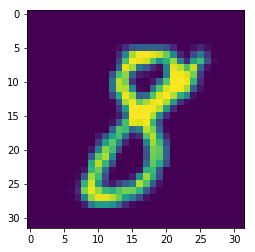

In [6]:
# print(train_digits_of_interest[5,0,0:31,0:31])
plt.imshow(train_digits_of_interest[5,0,:,:])

In [6]:
'''
datasets_even_even, datasets_even_odd, datasets_odd_even, datasets_odd_odd
represents four locations in one 2*2 patch
'''
from copy import deepcopy
def periodic_sampling(datasets):
    
    l = np.arange(32)
    evenmask = (l%2 == 0)
    oddmask = (l%2 == 1)
    datasets_even = deepcopy(datasets[:,:,evenmask,:])
#     plt.imshow(datasets_even[0,0,:,:])
#     plt.show()
    datasets_odd = deepcopy(datasets[:,:,oddmask,:])
#     plt.imshow(datasets_odd[0,0,:,:])
#     plt.show()

    datasets_even_even = deepcopy(datasets_even[:,:,:,evenmask])
#     plt.imshow(datasets_even_even[0,0,:,:])
#     plt.show()

    datasets_even_odd = deepcopy(datasets_even[:,:,:,oddmask])
#     plt.imshow(datasets_even_odd[0,0,:,:])
#     plt.show()

    datasets_odd_even = deepcopy(datasets_odd[:,:,:,evenmask])
#     plt.imshow(datasets_odd_even[0,0,:,:])
#     plt.show()

    datasets_odd_odd = deepcopy(datasets_odd[:,:,:,oddmask])
#     plt.imshow(datasets_odd_odd[0,0,:,:])
#     plt.show()
    return datasets_even_even[:sample_num], datasets_even_odd[:sample_num], datasets_odd_even[:sample_num], datasets_odd_odd[:sample_num]


In [7]:
train_ee, train_eo, train_oe, train_oo = periodic_sampling(train_digits_of_interest)
print('even_even dataset shape is: ', train_ee.shape)


even_even dataset shape is:  (1000, 1, 16, 16)


In [ ]:
plt.imshow(train_ee[5,0,:,:])
plt.show()
plt.imshow(train_eo[5,0,:,:])
plt.show()
plt.imshow(train_oe[5,0,:,:])
plt.show()
plt.imshow(train_oo[5,0,:,:])
plt.show()

In [8]:
'''
@ depth: determine shape, initial: 0
'''
from itertools import product
def fit_pca_shape(datasets,depth):
    factor=np.power(4,depth)
    length=int(16/factor)
    #length=32/factor
    idx1=range(0,length,4)
    idx2=[i+4 for i in idx1]
    data_lattice=[datasets[:,:,i:j,k:l] for ((i,j),(k,l)) in product(zip(idx1,idx2),zip(idx1,idx2))]
    data_lattice=np.array(data_lattice)
    print('fit_pca_shape: data_lattice.shape: {}'.format(data_lattice.shape)) 

    #shape reshape
    data=np.reshape(data_lattice,(data_lattice.shape[0]*data_lattice.shape[1],data_lattice.shape[2],4,4))
    print('fit_pca_shape: reshape: {}'.format(data.shape)) 
    return data

In [9]:
'''
@ return: augmented anchors
'''
def PCA_and_augment(data_in):
    # data reshape
    data=np.reshape(data_in,(data_in.shape[0],-1))
    mean=np.mean(data,axis=0)
    datas_mean_remov = data - mean

    pca=PCA()
    datas_mean_remov.astype(np.float64)
    pca.fit(datas_mean_remov)
    comps=pca.components_

#     if comps[-1][0]<0:
#         for i in comps:
#             i*=-1
#     comps_aug=[vec*(-1) for vec in comps]
#     comps_complete=np.vstack((comps,comps_aug))
    
    return comps,mean

In [10]:
'''
@ Prepare shape changes. 
@ return filters for convolution
@ aug_anchors: [out_num*in_num,4] -> [out_num,in_num,2,2]
'''
def ret_filt_patches(aug_anchors,input_channels):
    shape=int(aug_anchors.shape[1]/16)
    num=int(aug_anchors.shape[0])
    filt=np.reshape(aug_anchors,(num,shape,16))
    
    # reshape to kernels, (# output_channels,# input_channels,4,4)
    filters=np.reshape(filt,(num,shape,4,4))

    return filters

In [11]:
'''
@ input: kernel and data
@ output: conv result
'''
def conv(filters,datasets,stride=4):
    # torch data change
    
    filters_t=torch.from_numpy(filters)
    datasets_t=torch.from_numpy(datasets)

    # Variables
    filt=Variable(filters_t).type(torch.FloatTensor)
    data=Variable(datasets_t).type(torch.FloatTensor)

    # Convolution
    output=F.conv2d(data,filt,stride=stride)


    return output,filt

In [12]:
# import math

# def psnr(img1, img2):
#     mse = np.mean( (img1 - img2) ** 2 )
#     if mse == 0:
#         return 100
#     PIXEL_MAX = 1.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
def psnr(im1,im2):
    diff =(im1 - im2)
    diff=diff**2
    rmse=np.sqrt(np.mean(diff.sum()))
    psnr = 20*np.log10(1/rmse)
    return psnr

In [13]:
'''
@ One-stage Saak transform
@ input: datasets [60000,channel,size,size]
'''
def one_stage_saak_trans(train_ee,train_eo,train_oe,train_oo,depth=0):

    print('one_stage_saak_trans: periodic sampling dataset.shape {}'.format(train_ee.shape)) 
    input_channels=train_ee.shape[1]

    data_flatten_ee = fit_pca_shape(train_ee,depth)
    data_flatten_eo = fit_pca_shape(train_eo,depth)
    data_flatten_oe = fit_pca_shape(train_oe,depth)
    data_flatten_oo = fit_pca_shape(train_oo,depth)

    
    # comps,mean=PCA_and_augment(data_flatten)
    comps_ee,mean_ee=PCA_and_augment(data_flatten_ee)
    comps_eo,mean_eo=PCA_and_augment(data_flatten_eo)
    comps_oe,mean_oe=PCA_and_augment(data_flatten_oe)
    comps_oo,mean_oo=PCA_and_augment(data_flatten_oo)

    # filters=ret_filt_patches(comps,input_channels)
    filters_ee=ret_filt_patches(comps_ee,input_channels)
    filters_eo=ret_filt_patches(comps_eo,input_channels)
    filters_oe=ret_filt_patches(comps_oe,input_channels)
    filters_oo=ret_filt_patches(comps_oo,input_channels)
    print('one_stage_saak_trans: filters: {}'.format(filters_ee.shape)) 

    # mean=np.mean(datasets,axis=0)
    # datasets-=mean
    # output,filt=conv_and_relu(filters,datasets,stride=4)
    # res=output.data.numpy()

    mean_ee=np.mean(train_ee,axis=0)
    train_ee-=mean_ee
    output_ee,filt_ee=conv(filters_ee,train_ee,stride=4)
    res_ee=output_ee.data.numpy()
    
    mean_eo=np.mean(train_eo,axis=0)
    train_eo-=mean_eo
    output_eo,filt_eo=conv(filters_eo,train_eo,stride=4)
    res_eo=output_eo.data.numpy()
    
    mean_oe=np.mean(train_oe,axis=0)
    train_oe-=mean_oe
    output_oe,filt_oe=conv(filters_oe,train_oe,stride=4)
    res_oe=output_oe.data.numpy()

    mean_oo=np.mean(train_oo,axis=0)
    train_oo-=mean_oo
    output_oo,filt_oo=conv(filters_oo,train_oo,stride=4)
    res_oo=output_oo.data.numpy()
   
    print('one_stage_saak_trans final.shape: {}'.format(res_ee.shape)) 

    return res_ee, res_eo, res_oe, res_oo, filt_ee, filt_eo, filt_oe, filt_oo, mean_ee, mean_eo, mean_oe, mean_oo
# Variable(torch.from_numpy(res))

In [14]:
res1_ee, res1_eo, res1_oe, res1_oo, filt1_ee, filt1_eo, filt1_oe, filt1_oo, mean1_ee, mean1_eo, mean1_oe, mean1_oo = one_stage_saak_trans(train_ee,train_eo,train_oe,train_oo,depth=0)

one_stage_saak_trans: periodic sampling dataset.shape (1000, 1, 16, 16)
fit_pca_shape: data_lattice.shape: (16, 1000, 1, 4, 4)
fit_pca_shape: reshape: (16000, 1, 4, 4)
fit_pca_shape: data_lattice.shape: (16, 1000, 1, 4, 4)
fit_pca_shape: reshape: (16000, 1, 4, 4)
fit_pca_shape: data_lattice.shape: (16, 1000, 1, 4, 4)
fit_pca_shape: reshape: (16000, 1, 4, 4)
fit_pca_shape: data_lattice.shape: (16, 1000, 1, 4, 4)
fit_pca_shape: reshape: (16000, 1, 4, 4)
one_stage_saak_trans: filters: (16, 1, 4, 4)
one_stage_saak_trans final.shape: (1000, 16, 4, 4)


In [30]:
'''
@ debug: randomly zero one slice
'''
def deb_zero_slice(res1_ee, filt1_ee, mean1_ee, slice_num):
    deb_res1_ee_1 = deepcopy(res1_ee)
    deb_res1_ee_1[:,slice_num,:,:] = 0
    deb_res1_ee_1t = Variable(torch.from_numpy(deb_res1_ee_1))
    deb_train_ee_1t = F.conv_transpose2d(deb_res1_ee_1t, filt1_ee, stride=4)
    deb_train_ee_1t += Variable(torch.from_numpy(mean1_ee))
    deb_train_ee_1 = deb_train_ee_1t.data.numpy()
    # plt.imshow(deb_train_ee_1[5,0,:,:])
    plt.show()
    return deb_train_ee_1

In [26]:
# last slice zero
deb_train_ee_16 = deb_zero_slice(res1_ee, filt1_ee, mean1_ee, -1)
deb_train_eo_16 = deb_zero_slice(res1_eo, filt1_eo, mean1_eo, -1)
deb_train_oe_16 = deb_zero_slice(res1_oe, filt1_oe, mean1_oe, -1)
deb_train_oo_16 = deb_zero_slice(res1_oo, filt1_oo, mean1_oo, -1)

In [31]:
# third slice zero
deb_train_ee_7 = deb_zero_slice(res1_ee, filt1_ee, mean1_ee, 6)
deb_train_eo_7 = deb_zero_slice(res1_eo, filt1_eo, mean1_eo, 6)
deb_train_oe_7 = deb_zero_slice(res1_oe, filt1_oe, mean1_oe, 6)
deb_train_oo_7 = deb_zero_slice(res1_oo, filt1_oo, mean1_oo, 6)

In [33]:
# third slice zero
deb_train_ee_13 = deb_zero_slice(res1_ee, filt1_ee, mean1_ee, 12)
deb_train_eo_13 = deb_zero_slice(res1_eo, filt1_eo, mean1_eo, 12)
deb_train_oe_13 = deb_zero_slice(res1_oe, filt1_oe, mean1_oe, 12)
deb_train_oo_13 = deb_zero_slice(res1_oo, filt1_oo, mean1_oo, 12)

In [20]:
'''
@ debug reconstruct from the first stage
'''
def recon_from_first(res1_ee, filt1_ee, mean1_ee):
    # print(mean1_ee.shape)
    res1_ee_t = Variable(torch.from_numpy(res1_ee))
    # filt1_ee_t = Variable(torch.from_numpy(filt1_ee))
    debug1_ee = F.conv_transpose2d(res1_ee_t, filt1_ee, stride=4)
    # print(debug1_ee.data.numpy().shape)
    # mean1_ee=np.reshape(mean2_ee,(8,4,4))
    debug1_ee += Variable(torch.from_numpy(mean1_ee))
    debug1_ee = debug1_ee.data.numpy()
    print('reconstructed shape:', debug1_ee.shape)
    return debug1_ee
    # plt.imshow(debug1_ee[5,0,:,:])
    # psnr(train_ee[5,0,:,:], debug1_ee[5,0,:,:])

In [21]:
debug1ee = recon_from_first(res1_ee, filt1_ee, mean1_ee)
debug1eo = recon_from_first(res1_eo, filt1_eo, mean1_eo)
debug1oe = recon_from_first(res1_oe, filt1_oe, mean1_oe)
debug1oo = recon_from_first(res1_oo, filt1_oo, mean1_oo)


reconstructed shape: (1000, 1, 16, 16)
reconstructed shape: (1000, 1, 16, 16)
reconstructed shape: (1000, 1, 16, 16)
reconstructed shape: (1000, 1, 16, 16)


In [18]:
'''
@ reconstruct four images to one 32*32
'''
def reverse_downsample(rec2_ee, rec2_eo, rec2_oe, rec2_oo):
    syn = np.zeros((sample_num,1,32,32))
    print(syn[:,:,1::2,1::2].shape)
    syn[:,:,0:-1:2,0:-1:2]=rec2_ee
    syn[:,:,0:-1:2,1::2]=rec2_eo
    syn[:,:,1::2,0:-1:2]=rec2_oe
    syn[:,:,1::2,1::2]=rec2_oo

    # print(syn[5,0,0:31, 0:31])
    plt.imshow(syn[5,0,:,:])
    plt.show()
    print('psnr:', psnr(train_digits_of_interest[5,0,:,:], syn[5,0,:,:]))
    return syn

(1000, 1, 16, 16)


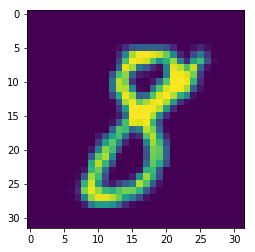

psnr: 109.73274005103801


In [22]:
debug1 = reverse_downsample(debug1ee, debug1eo, debug1oe, debug1oo)

In [23]:
'''
@ debug: lossless second stage saak transform
'''
deres2_ee, deres2_eo, deres2_oe, deres2_oo,defilt2_ee, defilt2_eo, defilt2_oe, defilt2_oo, demean2_ee, demean2_eo, demean2_oe, demean2_oo = one_stage_saak_trans(res1_ee,res1_eo,res1_oe,res1_oo,depth=1)

one_stage_saak_trans: periodic sampling dataset.shape (1000, 16, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 16, 4, 4)
fit_pca_shape: reshape: (1000, 16, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 16, 4, 4)
fit_pca_shape: reshape: (1000, 16, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 16, 4, 4)
fit_pca_shape: reshape: (1000, 16, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 16, 4, 4)
fit_pca_shape: reshape: (1000, 16, 4, 4)
one_stage_saak_trans: filters: (256, 16, 4, 4)
one_stage_saak_trans final.shape: (1000, 256, 1, 1)


In [26]:
'''
@ debug: reconstruct using lossless result
'''
def recon_from_second(deres2_ee, defilt2_ee, demean2_ee, filt1_ee, mean1_ee):
    # first recon
    deres2_ee_t = Variable(torch.from_numpy(deres2_ee))
    debugrec1_ee = F.conv_transpose2d(deres2_ee_t, defilt2_ee, stride=4)
    # print(debugrec1_ee.data.numpy().shape)
    debugrec1_ee += Variable(torch.from_numpy(demean2_ee))
    # debugrec1_ee = debugrec1_ee.data.numpy()
    print(debugrec1_ee.data.numpy().shape)

    # second recon
    debugrec2_ee = F.conv_transpose2d(debugrec1_ee, filt1_ee, stride=4)
    # print(debugrec2_ee.data.numpy().shape)
    debugrec2_ee += Variable(torch.from_numpy(mean1_ee))
    debugrec2_ee = debugrec2_ee.data.numpy()
    print(debugrec2_ee.shape)
    # plt.imshow(debugrec2_ee[5,0,:,:])
    # psnr(train_ee[5,0,:,:], debugrec2_ee[5,0,:,:])
    return debugrec2_ee


In [27]:
debug2ee = recon_from_second(deres2_ee, defilt2_ee, demean2_ee, filt1_ee, mean1_ee)
debug2eo = recon_from_second(deres2_eo, defilt2_eo, demean2_eo, filt1_eo, mean1_eo)
debug2oe = recon_from_second(deres2_oe, defilt2_oe, demean2_oe, filt1_oe, mean1_oe)
debug2oo = recon_from_second(deres2_oo, defilt2_oo, demean2_oo, filt1_oo, mean1_oo)


(1000, 16, 4, 4)
(1000, 1, 16, 16)
(1000, 16, 4, 4)
(1000, 1, 16, 16)
(1000, 16, 4, 4)
(1000, 1, 16, 16)
(1000, 16, 4, 4)
(1000, 1, 16, 16)


(1000, 1, 16, 16)


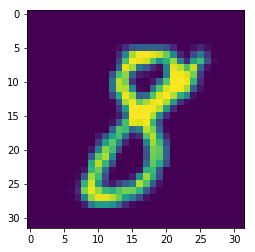

psnr: 104.14869711779718


In [28]:
debug2 = reverse_downsample(debug2ee, debug2eo, debug2oe, debug2oo)

In [29]:
'''
@ low, middle, high frequency should be in terms of the result of first stage.
'''
res1_ee_low = deepcopy(res1_ee[:,:low_channel,:,:])
res1_eo_low = deepcopy(res1_eo[:,:low_channel,:,:])
res1_oe_low = deepcopy(res1_oe[:,:low_channel,:,:])
res1_oo_low = deepcopy(res1_oo[:,:low_channel,:,:])

if (low_channel != mid_channel):
    print('true')
    res1_ee_mid = deepcopy(res1_ee[:,low_channel:mid_channel,:,:])
    res1_eo_mid = deepcopy(res1_eo[:,low_channel:mid_channel,:,:])
    res1_oe_mid = deepcopy(res1_oe[:,low_channel:mid_channel,:,:])
    res1_oo_mid = deepcopy(res1_oo[:,low_channel:mid_channel,:,:])

if (hig_channel != 0):
    print('false')
    res1_ee_hig = np.zeros((sample_num,hig_channel,4,4))
    res1_eo_hig = np.zeros((sample_num,hig_channel,4,4))    
    res1_oe_hig = np.zeros((sample_num,hig_channel,4,4))
    res1_oo_hig = np.zeros((sample_num,hig_channel,4,4)) 


false


In [30]:
print(res1_ee_low.shape)
# print(res1_ee_mid.shape)
print(res1_ee_hig.shape)
hig_channel

(1000, 15, 4, 4)
(1000, 1, 4, 4)


1

In [31]:
res2_ee_low, res2_eo_low, res2_oe_low, res2_oo_low, filt2_ee_low, filt2_eo_low, filt2_oe_low, filt2_oo_low, mean2_ee_low, mean2_eo_low, mean2_oe_low, mean2_oo_low = one_stage_saak_trans(res1_ee_low, res1_eo_low, res1_oe_low, res1_oo_low, 1)
# 现在是全部保留，后面res2_ee_low要截取一部分

one_stage_saak_trans: periodic sampling dataset.shape (1000, 15, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 15, 4, 4)
fit_pca_shape: reshape: (1000, 15, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 15, 4, 4)
fit_pca_shape: reshape: (1000, 15, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 15, 4, 4)
fit_pca_shape: reshape: (1000, 15, 4, 4)
fit_pca_shape: data_lattice.shape: (1, 1000, 15, 4, 4)
fit_pca_shape: reshape: (1000, 15, 4, 4)
one_stage_saak_trans: filters: (240, 15, 4, 4)
one_stage_saak_trans final.shape: (1000, 240, 1, 1)


In [ ]:
'''
@ debug: randomly pick up a slice of res1_ee and set it to zero
'''
deb_res2_ee, deb_res2_eo, deb_res2_oe, deb_res2_oo, deb_filt2_ee, deb_filt2_eo, deb_filt2_oe, deb_filt2_oo, deb_mean2_ee, deb_mean2_eo, deb_mean2_oe, deb_mean2_oo = one_stage_saak_trans(res1_ee[:,1:16,:,:], res1_eo[:,1:16,:,:], res1_oe[:,1:16,:,:], res1_oo[:,1:16,:,:], 1)


In [ ]:
'''
@ debug
'''
def debug_throw_1st_res1(deb_res2_ee, deb_filt2_ee, deb_mean2_ee, filt1_ee, mean1_ee):
    # first reconstruction
    deb_res2_ee_t = Variable(torch.from_numpy(deb_res2_ee))
    deb_rec1_ee = F.conv_transpose2d(deb_res2_ee_t, deb_filt2_ee, stride=4)
    print(deb_rec1_ee.data.numpy().shape)
    deb_rec1_ee += Variable(torch.from_numpy(deb_mean2_ee))

    # concatenate with res1_ee 1st slice
    temp_res1_ee_1 = np.zeros((sample_num, 1, 4, 4))
    temp_res1_ee_1t = Variable(torch.from_numpy(temp_res1_ee_1)).type(torch.FloatTensor)

    deb_ee_comb_t = torch.cat((temp_res1_ee_1t, deb_rec1_ee),1)
    print(deb_ee_comb_t.data.numpy().shape)

    # second reconstruction
    deb_rec2_ee = F.conv_transpose2d(deb_ee_comb_t, filt1_ee, stride=4)
    # print(rec2_ee.data.numpy().shape)
    deb_rec2_ee += Variable(torch.from_numpy(mean1_ee))
    deb_rec2_ee = deb_rec2_ee.data.numpy()
    print('final reconstructed shape: ', deb_rec2_ee.shape)
    plt.imshow(deb_rec2_ee[5,0,:,:])
    plt.show()
    return deb_rec2_ee

In [ ]:
deb_rec2_ee = debug_throw_1st_res1(deb_res2_ee, deb_filt2_ee, deb_mean2_ee, filt1_ee, mean1_ee)
deb_rec2_eo = debug_throw_1st_res1(deb_res2_eo, deb_filt2_eo, deb_mean2_eo, filt1_eo, mean1_eo)
deb_rec2_oe = debug_throw_1st_res1(deb_res2_oe, deb_filt2_oe, deb_mean2_oe, filt1_oe, mean1_oe)
deb_rec2_oo = debug_throw_1st_res1(deb_res2_oo, deb_filt2_oo, deb_mean2_oo, filt1_oo, mean1_oo)

In [32]:
'''
@ reconstruction: using low freq part
'''
def two_recon(res2_ee_low, filt2_ee_low, mean2_ee_low, filt1_ee, mean1_ee, res1_ee_mid=None, res1_ee_hig=None):
    # first recon
    # res2_ee_low_r = np.flip(res2_ee_low, axis=1)
    res2_ee_lowt = Variable(torch.from_numpy(res2_ee_low))
    rec1_ee_low = F.conv_transpose2d(res2_ee_lowt, filt2_ee_low, stride=4)
    print('reconstructed low freq shape:', rec1_ee_low.data.numpy().shape)
    rec1_ee_low += Variable(torch.from_numpy(mean2_ee_low))
    # debugrec1_ee = debugrec1_ee.data.numpy()

    # concatenate with mid and high
    print('---combination starts---')
    if (low_channel != mid_channel): # low<mid 
        if (hig_channel != 0): # low<mid<high
            res1_ee_hig_t = Variable(torch.from_numpy(res1_ee_hig)).type(torch.FloatTensor)
            res1_ee_mid_t = Variable(torch.from_numpy(res1_ee_mid))
            ee_comb1_t = torch.cat((rec1_ee_low, res1_ee_mid_t), 1)
            # print(ee_comb1.data.numpy().shape)
            ee_comb_t = torch.cat((ee_comb1_t, res1_ee_hig_t), 1)
        else: # low<mid=high
            ee_comb_t = torch.cat((rec1_ee_low, res1_ee_mid_t), 1)

    else: # low=mid  
        if (hig_channel != 0): # low=mid<16
            res1_ee_hig_t = Variable(torch.from_numpy(res1_ee_hig)).type(torch.FloatTensor)
            ee_comb_t = torch.cat((rec1_ee_low, res1_ee_hig_t), 1)
        else: # low=mid=16
            ee_comb = deepcopy(rec1_ee_low.data.numpy())
            ee_comb_t = Variable(torch.from_numpy(ee_comb))
    print('first comb shape: ', ee_comb_t.data.numpy().shape)
    
#     ee_comb = ee_comb_t.data.numpy()
#     ee_comb_r = np.flip(ee_comb, axis=1)
#     ee_comb_rt = Variable(torch.from_numpy(ee_comb_r.copy()))

    # second recon
    rec2_ee = F.conv_transpose2d(ee_comb_t, filt1_ee, stride=4)
    # print(rec2_ee.data.numpy().shape)
    rec2_ee += Variable(torch.from_numpy(mean1_ee))
    rec2_ee = rec2_ee.data.numpy()
    print('final reconstructed shape: ', rec2_ee.shape)
    plt.imshow(rec2_ee[5,0,:,:])
    plt.show()
    # psnr(train_ee[5,0,:,:], rec2_ee[5,0,:,:])
    return rec2_ee



reconstructed low freq shape: (1000, 15, 4, 4)
---combination starts---
first comb shape:  (1000, 16, 4, 4)
final reconstructed shape:  (1000, 1, 16, 16)


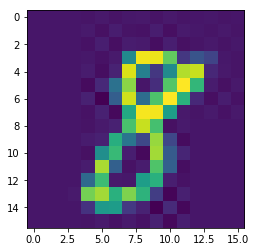

reconstructed low freq shape: (1000, 15, 4, 4)
---combination starts---
first comb shape:  (1000, 16, 4, 4)
final reconstructed shape:  (1000, 1, 16, 16)


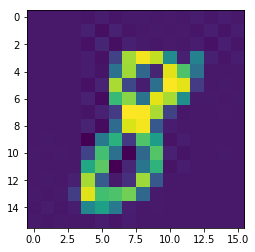

reconstructed low freq shape: (1000, 15, 4, 4)
---combination starts---
first comb shape:  (1000, 16, 4, 4)
final reconstructed shape:  (1000, 1, 16, 16)


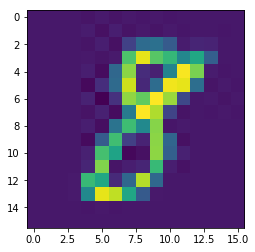

reconstructed low freq shape: (1000, 15, 4, 4)
---combination starts---
first comb shape:  (1000, 16, 4, 4)
final reconstructed shape:  (1000, 1, 16, 16)


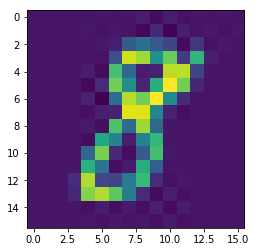

In [33]:
rec2_ee = two_recon(res2_ee_low, filt2_ee_low, mean2_ee_low, filt1_ee, mean1_ee, res1_ee_hig=res1_ee_hig)
rec2_eo = two_recon(res2_eo_low, filt2_eo_low, mean2_eo_low, filt1_eo, mean1_eo, res1_ee_hig=res1_eo_hig)
rec2_oe = two_recon(res2_oe_low, filt2_oe_low, mean2_oe_low, filt1_oe, mean1_oe, res1_ee_hig=res1_oe_hig)
rec2_oo = two_recon(res2_oo_low, filt2_oo_low, mean2_oo_low, filt1_oo, mean1_oo, res1_ee_hig=res1_oo_hig)

In [34]:
'''
@ reconstruct four images to one 32*32
'''
def reverse_downsample(rec2_ee, rec2_eo, rec2_oe, rec2_oo):
    syn = np.zeros((sample_num,1,32,32))
    print(syn[:,:,1::2,1::2].shape)
    syn[:,:,0:-1:2,0:-1:2]=rec2_ee
    syn[:,:,0:-1:2,1::2]=rec2_eo
    syn[:,:,1::2,0:-1:2]=rec2_oe
    syn[:,:,1::2,1::2]=rec2_oo

    # print(syn[5,0,0:31, 0:31])
    plt.imshow(syn[5,0,:,:])
    plt.show()
    print('psnr:', psnr(train_digits_of_interest[5,0,:,:], syn[5,0,:,:]))
    return syn

(1000, 1, 16, 16)


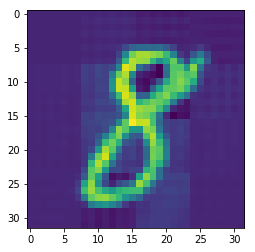

psnr: -5.94746042276989


In [35]:
deb_syn = reverse_downsample(deb_train_ee_1, deb_train_eo_1, deb_train_oe_1, deb_train_oo_1)

(1000, 1, 16, 16)


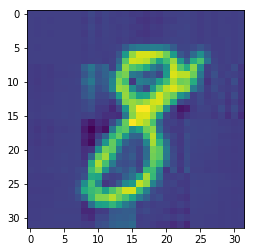

psnr: -6.1628271817034355


In [44]:
deb_syn_2 = reverse_downsample(deb_train_ee_2, deb_train_eo_2, deb_train_oe_2, deb_train_oo_2)

(1000, 1, 16, 16)


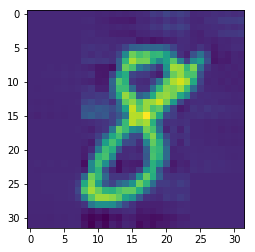

psnr: -3.793913660834725


In [46]:
deb_syn_3 = reverse_downsample(deb_train_ee_3, deb_train_eo_3, deb_train_oe_3, deb_train_oo_3)

(1, 32, 32)


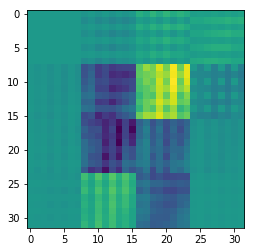

In [36]:
err_1 = train_digits_of_interest[5,:,:,:] - deb_syn[5,:,:,:]
print(err_1.shape)
plt.imshow(err_1[0,:,:])

(1000, 1, 16, 16)


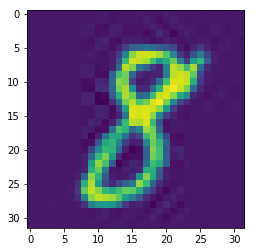

psnr: 3.97850859678917


In [37]:
deb_syn_16 = reverse_downsample(deb_train_ee_16, deb_train_eo_16, deb_train_oe_16, deb_train_oo_16)

(1000, 1, 16, 16)


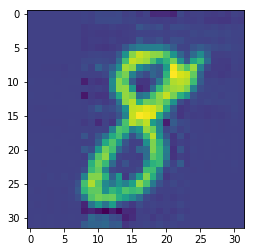

psnr: -4.5169938737864985


In [32]:
deb_syn_7 = reverse_downsample(deb_train_ee_7, deb_train_eo_7, deb_train_oe_7, deb_train_oo_7)

(1000, 1, 16, 16)


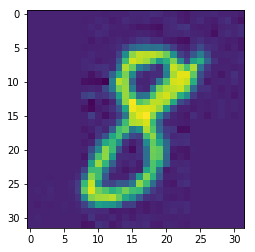

psnr: 1.4542349393309628


In [34]:
deb_syn_13 = reverse_downsample(deb_train_ee_13, deb_train_eo_13, deb_train_oe_13, deb_train_oo_13)

(1000, 1, 16, 16)


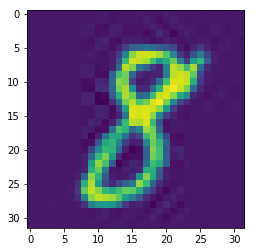

psnr: 3.978506920022509


In [38]:
syn = reverse_downsample(rec2_ee, rec2_eo, rec2_oe, rec2_oo)

(1, 32, 32)


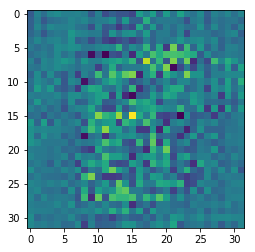

In [41]:
err_2 = (deb_syn_16-syn)[5,:,:,:]
print(err_2.shape)
plt.imshow(err_2[0,:,:])